In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [10]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_1 = Add()([features_1, embedding_dropout])
features_2 = one_by_one(filtersNumber, features_1)
features_2 = Add()([features_2, features_1])
features_3 = one_by_one(filtersNumber, features_2)
features_3 = Add()([features_3, features_2])

features_4 = one_by_one(filtersNumber, features_3)
features_4 = Add()([features_4, features_3])
features_5 = one_by_one(filtersNumber, features_4)
features_5 = Add()([features_5, features_4])
features_6 = one_by_one(filtersNumber, features_5)
features_6 = Add()([features_6, features_5])

features = yoon_kim_feature_extractor(filtersNumber, features_6)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________

In [11]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 18336/102124 [====>.........................] - ETA: 9:03 - loss: 0.1976 - acc: 0.9208 49344/102124 [=============>................] - ETA: 5:34 - loss: 0.1168 - acc: 0.9558 81152/102124 [======================>.......] - ETA: 2:11 - loss: 0.0965 - acc: 0.9640102124/102124 [==============================] - 688s 7ms/step - loss: 0.0885 - acc: 0.9671 - val_loss: 0.0542 - val_acc: 0.9793
Epoch 2/32
  4128/102124 [>.............................] - ETA: 10:08 - loss: 0.0535 - acc: 0.9797 35168/102124 [=========>....................] - ETA: 6:56 - loss: 0.0566 - acc: 0.9790 65824/102124 [==================>...........] - ETA: 3:46 - loss: 0.0566 - acc: 0.9791 96224/102124 [===========================>..] - ETA: 36s - loss: 0.0564 - acc: 0.9793102124/102124 [==============================] - 684s 7ms/step - loss: 0.0562 - acc: 0.9794 - val_loss: 0.0449 - val_acc: 0.9830
roc-auc: 0.9816 - roc-auc_val: 0.9793                       

  1536/102124 [..............................] - ETA: 10:19 - loss: 0.0371 - acc: 0.9848 34560/102124 [=========>....................] - ETA: 6:57 - loss: 0.0352 - acc: 0.9858 67040/102124 [==================>...........] - ETA: 3:37 - loss: 0.0361 - acc: 0.9855100448/102124 [============================>.] - ETA: 10s - loss: 0.0364 - acc: 0.9853102124/102124 [==============================] - 679s 7ms/step - loss: 0.0364 - acc: 0.9854 - val_loss: 0.0403 - val_acc: 0.9845
Epoch 18/32
 11648/102124 [==>...........................] - ETA: 9:20 - loss: 0.0350 - acc: 0.9858 44032/102124 [===========>..................] - ETA: 5:59 - loss: 0.0352 - acc: 0.9859 76000/102124 [=====================>........] - ETA: 2:41 - loss: 0.0360 - acc: 0.9855102124/102124 [==============================] - 679s 7ms/step - loss: 0.0361 - acc: 0.9854 - val_loss: 0.0398 - val_acc: 0.9845
roc-auc: 0.9952 - roc-auc_val: 0.9879                                                                                    

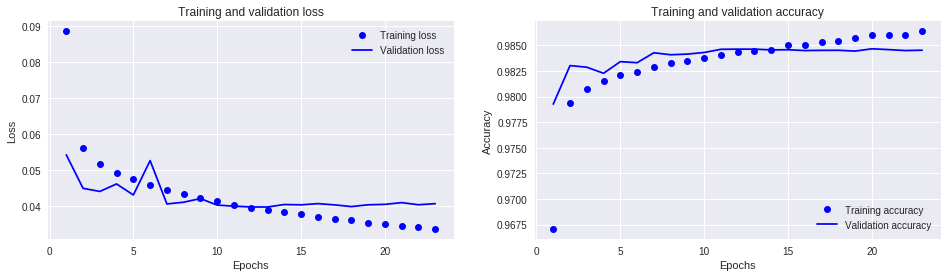

In [12]:
plot_history(history)

In [13]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 63s 2ms/step
([0.03925089866606355, 0.9849443707536347], 0.989641499587904)
